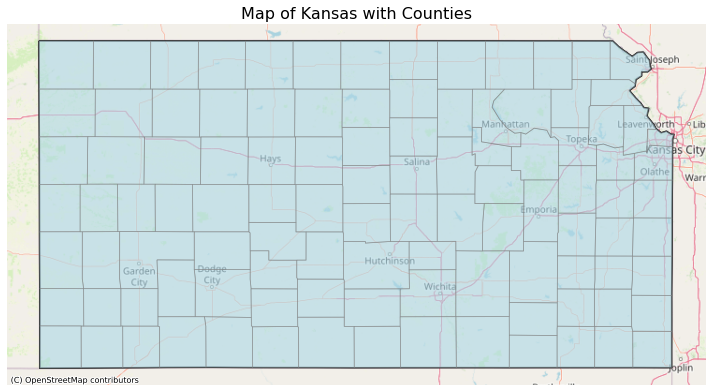

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import os

statefp = "cb_2021_us_state_20m.shp"
state = gpd.read_file(statefp)
countyfp = "cb_2021_us_county_20m.shp"
county = gpd.read_file(countyfp)


kansas = state[state['NAME'] == 'Kansas']
kansas_county = county[county['STATEFP'] == '20']

outfp = "2021_county_kansas_20m.shp"
kansas_county.to_file(outfp)
kansas = kansas.to_crs(epsg=3857)
kansas_county = kansas_county.to_crs(epsg=3857)


fig, ax = plt.subplots(figsize=(10, 12))
kansas.plot(ax=ax, edgecolor = 'black', facecolor='none', linewidth=1.5)
kansas_county.plot(ax=ax, edgecolor='gray', facecolor= 'lightblue', alpha =.6, linewidth=0.8)

ctx.add_basemap(ax, source= ctx.providers.OpenStreetMap.Mapnik)

ax.set_title("Map of Kansas with Counties", fontsize=16)
ax.axis('off')

plt.tight_layout()
plt.show()



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


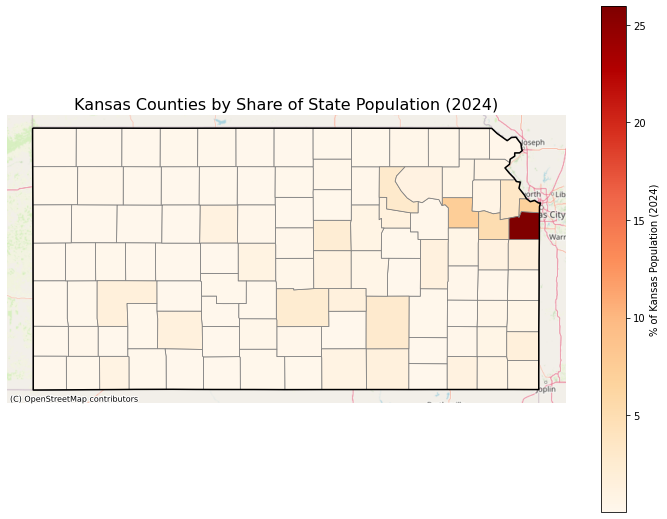

In [5]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import pandas as pd

# Load shapefiles
state = gpd.read_file("cb_2021_us_state_20m.shp")
county = gpd.read_file("cb_2021_us_county_20m.shp")

# Filter for Kansas
kansas = state[state['NAME'] == 'Kansas']
kansas_county = county[county['STATEFP'] == '20']

# Load population CSV
pop_df = pd.read_csv("kansas_pop_county.csv")

# Get total Kansas population from the special row
total_pop = pop_df.loc[pop_df['County'] == 'Kansas', 'Population.2024'].values[0]

# Filter out the total row for merging
county_pop_df = pop_df[pop_df['County'] != 'Kansas'].copy()

# Ensure FIPS codes match
county_pop_df["fips"] = county_pop_df["fips"].astype(str).str.zfill(5)
kansas_county["GEOID"] = kansas_county["GEOID"].astype(str).str.zfill(5)

# Merge population into GeoDataFrame
kansas_county = kansas_county.merge(county_pop_df, left_on="GEOID", right_on="fips")

# Compute population share (as percentage)
kansas_county["pop_pct"] = (kansas_county["Population.2024"] / total_pop) * 100

# Reproject to match basemap
kansas = kansas.to_crs(epsg=3857)
kansas_county = kansas_county.to_crs(epsg=3857)

# Plot
fig, ax = plt.subplots(figsize=(10, 12))

kansas_county.plot(
    column="pop_pct",
    cmap="OrRd",
    legend=True,
    legend_kwds={"label": "% of Kansas Population (2024)", "shrink": 0.6},
    ax=ax,
    edgecolor="gray",
    linewidth=0.8
)

kansas.boundary.plot(ax=ax, edgecolor='black', linewidth=1.5)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_title("Kansas Counties by Share of State Population (2024)", fontsize=16)
ax.axis('off')
plt.tight_layout()



In [32]:
import folium
from folium import Choropleth, LayerControl, GeoJsonTooltip

# Reproject to WGS84 for web map
kansas_county_web = kansas_county.to_crs(epsg=4326)

# Create base map centered on Kansas
m = folium.Map(location=[38.5, -98.5], zoom_start=6, tiles="cartodbpositron")

# Utility: Add choropleth layer function
def add_choropleth(geo_df, column, name, color_scale, legend_name):
    choropleth = Choropleth(
        geo_data=geo_df,
        name=name,
        data=geo_df,
        columns=["County", column],
        key_on="feature.properties.County",
        fill_color=color_scale,
        fill_opacity=0.7,
        line_opacity=0.2,
        nan_fill_color="gray",
        legend_name=legend_name,
    )
    choropleth.add_to(m)

    # Tooltip with County and value
    folium.GeoJson(
        geo_df,
        name=f"{name} Tooltip",
        tooltip=GeoJsonTooltip(
            fields=["County", column],
            aliases=["County", legend_name],
            localize=True,
        ),
        style_function=lambda x: {"weight": 0, "fillOpacity": 0},
    ).add_to(m)

# Add each layer
add_choropleth(kansas_county_web, "wind_per_10k", "Wind per 10k", "Blues", "Wind Projects per 10,000 People")
add_choropleth(kansas_county_web, "solar_per_10k", "Solar per 10k", "YlOrBr", "Solar Projects per 10,000 People")
add_choropleth(kansas_county_web, "fuel_per_10k", "Fuel per 10k", "Greens", "Fuel Stations per 10,000 People")

# Layer control to toggle
folium.LayerControl().add_to(m)

# Save to file and display
m.save("index.html")


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


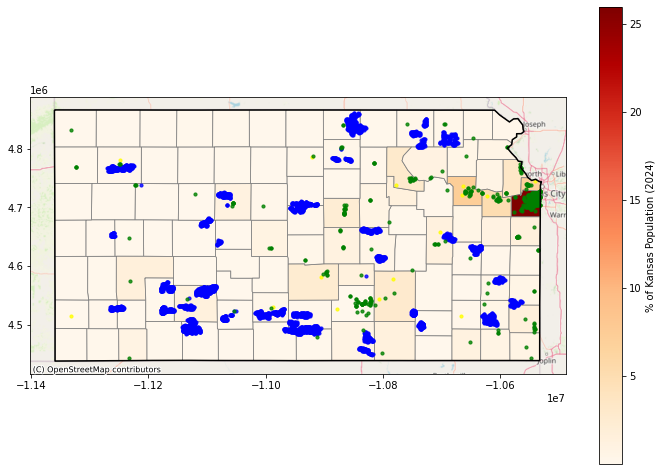

In [33]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import pandas as pd
from shapely.geometry import Point

# Load shapefiles
state = gpd.read_file("cb_2021_us_state_20m.shp")
county = gpd.read_file("cb_2021_us_county_20m.shp")

# Filter for Kansas
kansas = state[state['NAME'] == 'Kansas']
kansas_county = county[county['STATEFP'] == '20']

# Load population data
pop_df = pd.read_csv("kansas_pop_county.csv")
total_pop = pop_df.loc[pop_df['County'] == 'Kansas', 'Population.2024'].values[0]
county_pop_df = pop_df[pop_df['County'] != 'Kansas'].copy()
county_pop_df["fips"] = county_pop_df["fips"].astype(str).str.zfill(5)
kansas_county["GEOID"] = kansas_county["GEOID"].astype(str).str.zfill(5)
kansas_county = kansas_county.merge(county_pop_df, left_on="GEOID", right_on="fips")
kansas_county["pop_pct"] = (kansas_county["Population.2024"] / total_pop) * 100

# Load wind farm data and convert to GeoDataFrame
wind_df = pd.read_csv("KS_Data_wind.csv")
geometry = [Point(xy) for xy in zip(wind_df["xlong"], wind_df["ylat"])]
wind_gdf = gpd.GeoDataFrame(wind_df, geometry=geometry, crs="EPSG:4326")
wind_gdf = wind_gdf.to_crs(epsg=3857)
#load solar and convert to gdf
solar_df = pd.read_csv("KS_Data_solar.csv")
geom_s = [Point(xy) for xy in zip(solar_df["xlong"], solar_df["ylat"])]
solar_gdf = gpd.GeoDataFrame(solar_df, geometry=geom_s, crs="EPSG:4326")
solar_gdf = solar_gdf.to_crs(epsg=3857)
#load stations and convert
fuel_station_df = pd.read_csv("fuel_stations_kansas.csv")
geom_f = [Point(xy) for xy in zip(fuel_station_df["Longitude"], fuel_station_df["Latitude"])]
fuel_gdf = gpd.GeoDataFrame(fuel_station_df, geometry=geom_f, crs="EPSG:4326")
fuel_gdf = fuel_gdf.to_crs(epsg=3857)
# Reproject Kansas shapes
kansas = kansas.to_crs(epsg=3857)
kansas_county = kansas_county.to_crs(epsg=3857)

# Plot everything
fig, ax = plt.subplots(figsize=(12, 14))

# Counties by population percentage
kansas_county.plot(
    column="pop_pct",
    cmap="OrRd",
    legend=True,
    legend_kwds={"label": "% of Kansas Population (2024)", "shrink": 0.6},
    ax=ax,
    edgecolor="gray",
    linewidth=0.8
)

# State boundary
kansas.boundary.plot(ax=ax, edgecolor='black', linewidth=1.5)

# Wind farms
wind_gdf.plot(ax=ax, color="blue", markersize=10, alpha=0.8, label="Wind Projects")
solar_gdf.plot(ax=ax, color="yellow", markersize=10, alpha=0.8, label="Solar Projects")
fuel_gdf.plot(ax=ax, color="green", markersize=10, alpha=0.8, label="Fuel Stations")
# Basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


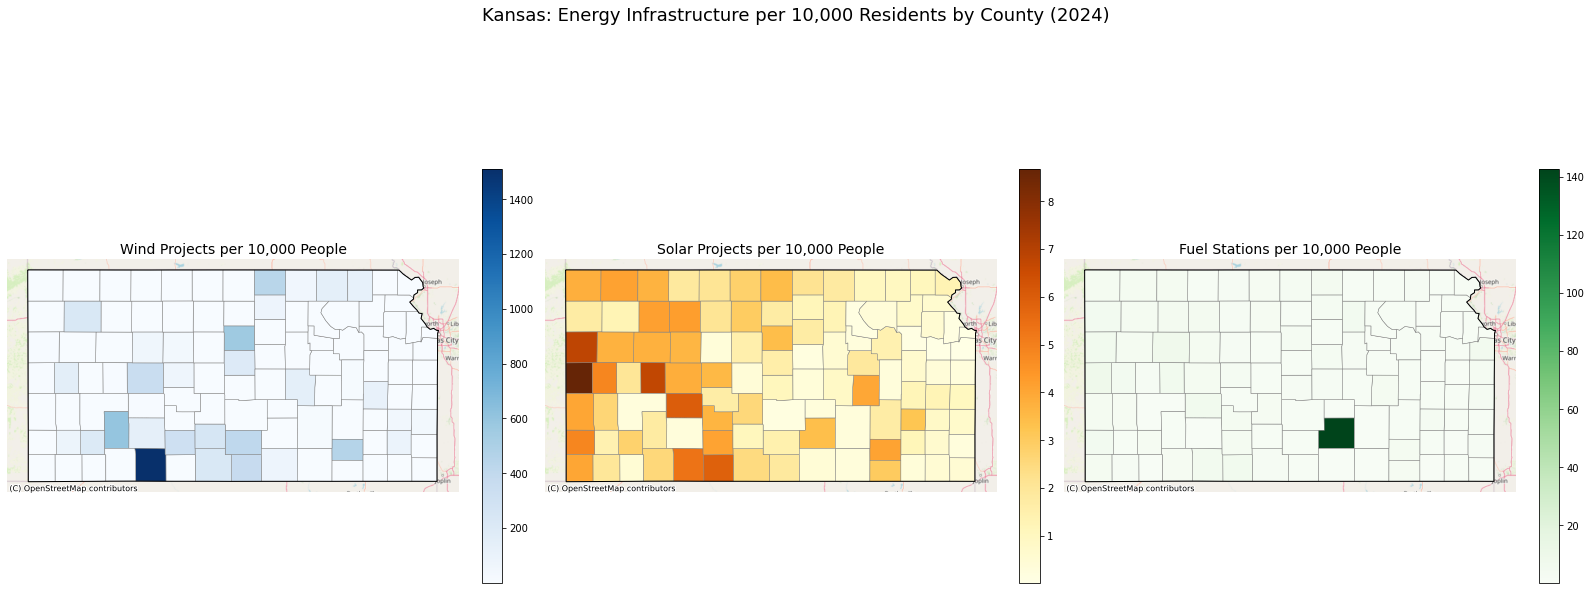

In [34]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import pandas as pd
from shapely.geometry import Point
import matplotlib.patches as mpatches

# Load shapefiles
state = gpd.read_file("cb_2021_us_state_20m.shp")
county = gpd.read_file("cb_2021_us_county_20m.shp")

# Filter for Kansas
kansas = state[state['NAME'] == 'Kansas']
kansas_county = county[county['STATEFP'] == '20']

# Load population data
pop_df = pd.read_csv("kansas_pop_county.csv")
total_pop = pop_df.loc[pop_df['County'] == 'Kansas', 'Population.2024'].values[0]
county_pop_df = pop_df[pop_df['County'] != 'Kansas'].copy()
county_pop_df["fips"] = county_pop_df["fips"].astype(str).str.zfill(5)
kansas_county["GEOID"] = kansas_county["GEOID"].astype(str).str.zfill(5)
kansas_county = kansas_county.merge(county_pop_df, left_on="GEOID", right_on="fips")
kansas_county["pop_pct"] = (kansas_county["Population.2024"] / total_pop) * 100

# Load wind farm data and convert to GeoDataFrame
wind_df = pd.read_csv("KS_Data_wind.csv")
geometry = [Point(xy) for xy in zip(wind_df["xlong"], wind_df["ylat"])]
wind_gdf = gpd.GeoDataFrame(wind_df, geometry=geometry, crs="EPSG:4326")
wind_gdf = wind_gdf.to_crs(epsg=3857)

# Load solar data
solar_df = pd.read_csv("KS_Data_solar.csv")
geom_s = [Point(xy) for xy in zip(solar_df["xlong"], solar_df["ylat"])]
solar_gdf = gpd.GeoDataFrame(solar_df, geometry=geom_s, crs="EPSG:4326")
solar_gdf = solar_gdf.to_crs(epsg=3857)

# Load fuel station data
fuel_station_df = pd.read_csv("stations_ks.csv")
geom_f = [Point(xy) for xy in zip(fuel_station_df["Longitude"], fuel_station_df["Latitude"])]
fuel_gdf = gpd.GeoDataFrame(fuel_station_df, geometry=geom_f, crs="EPSG:4326")
fuel_gdf = fuel_gdf.to_crs(epsg=3857)

# Reproject counties and state
kansas = kansas.to_crs(epsg=3857)
kansas_county = kansas_county.to_crs(epsg=3857)

# Calculate per capita facility counts
# Spatial join
wind_join = gpd.sjoin(kansas_county, wind_gdf, how="left", predicate="contains")
solar_join = gpd.sjoin(kansas_county, solar_gdf, how="left", predicate="contains")
fuel_join = gpd.sjoin(kansas_county, fuel_gdf, how="left", predicate="contains")

# Counts
wind_counts = wind_join.groupby("GEOID").size().rename("wind_count")
solar_counts = solar_join.groupby("GEOID").size().rename("solar_count")
fuel_counts = fuel_join.groupby("GEOID").size().rename("fuel_count")

# Merge counts
kansas_county = kansas_county.set_index("GEOID")
kansas_county = kansas_county.join([wind_counts, solar_counts, fuel_counts])
kansas_county = kansas_county.fillna(0)

# Per capita rates
kansas_county["wind_per_10k"] = (kansas_county["wind_count"] / kansas_county["Population.2024"]) * 10000
kansas_county["solar_per_10k"] = (kansas_county["solar_count"] / kansas_county["Population.2024"]) * 10000
kansas_county["fuel_per_10k"] = (kansas_county["fuel_count"] / kansas_county["Population.2024"]) * 10000

# Reset index
kansas_county = kansas_county.reset_index()

# Plot: 3 Subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(22, 10), constrained_layout=True)

layers = [
    ("wind_per_10k", "Wind Projects per 10,000 People", "Blues"),
    ("solar_per_10k", "Solar Projects per 10,000 People", "YlOrBr"),
    ("fuel_per_10k", "Fuel Stations per 10,000 People", "Greens")
]

for ax, (column, title, cmap) in zip(axes, layers):
    kansas_county.plot(
        column=column,
        cmap=cmap,
        legend=True,
        legend_kwds={"shrink": 0.6},
        ax=ax,
        edgecolor="gray",
        linewidth=0.5
    )
    kansas.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
    ax.set_title(title, fontsize=14)
    ax.set_axis_off()

plt.suptitle("Kansas: Energy Infrastructure per 10,000 Residents by County (2024)", fontsize=18)
plt.show()


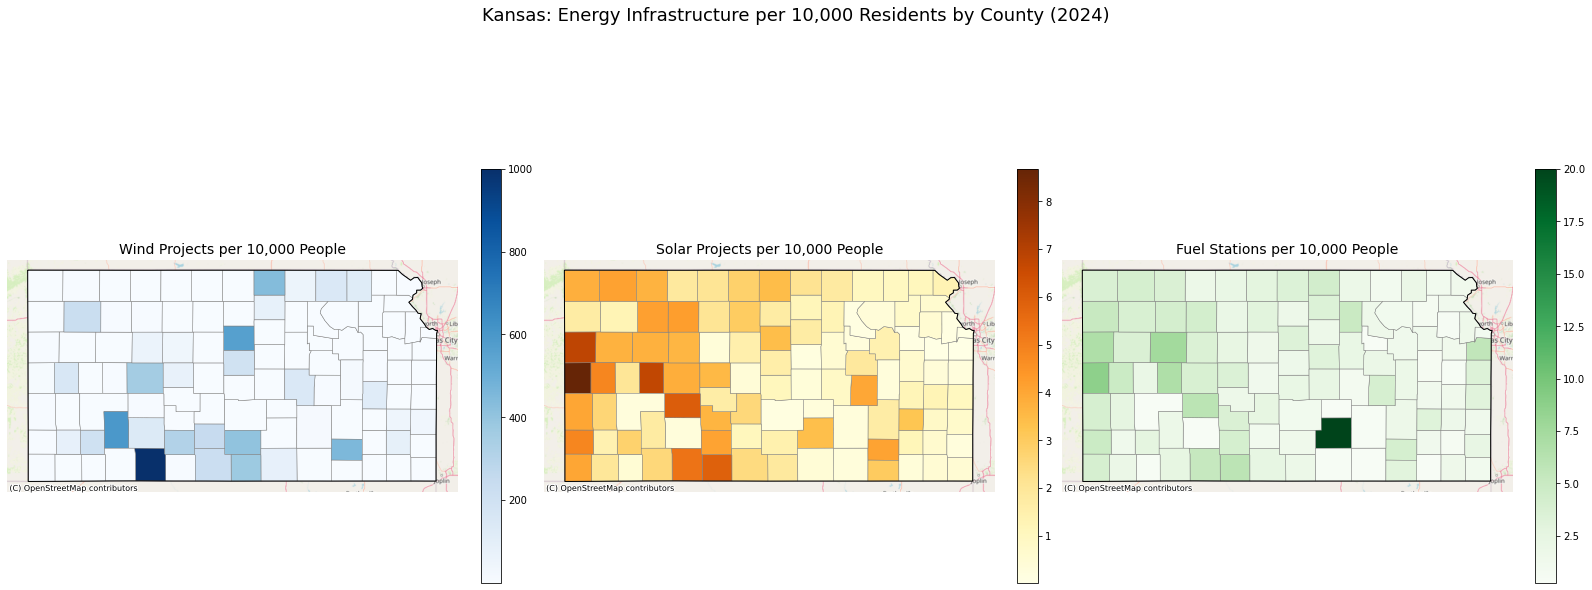

In [35]:
# Plot: 3 Subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(22, 10), constrained_layout=True)

layers = [
    ("wind_per_10k", "Wind Projects per 10,000 People", "Blues", 1000),
    ("solar_per_10k", "Solar Projects per 10,000 People", "YlOrBr", None),
    ("fuel_per_10k", "Fuel Stations per 10,000 People", "Greens", 20)
]

for ax, (column, title, cmap, vmax) in zip(axes, layers):
    plot_kwargs = {
        "column": column,
        "cmap": cmap,
        "legend": True,
        "legend_kwds": {"shrink": 0.6},
        "ax": ax,
        "edgecolor": "gray",
        "linewidth": 0.5
    }
    if vmax is not None:
        plot_kwargs["vmax"] = vmax

    kansas_county.plot(**plot_kwargs)
    kansas.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
    ax.set_title(title, fontsize=14)
    ax.set_axis_off()

plt.suptitle("Kansas: Energy Infrastructure per 10,000 Residents by County (2024)", fontsize=18)
plt.show()


In [36]:
# Check a few matches
print(fuel_join[["County", "City", "ZIP", "geometry"]].head())


       County          City      ZIP  \
0     Sherman      Goodland  67735.0   
0     Sherman      Goodland  67735.0   
0     Sherman      Goodland  67735.0   
1  Montgomery  Independence  67301.0   
2        Gove        Oakley  67748.0   

                                            geometry  
0  POLYGON ((-11360149.789 4803388.224, -11289345...  
0  POLYGON ((-11360149.789 4803388.224, -11289345...  
0  POLYGON ((-11360149.789 4803388.224, -11289345...  
1  POLYGON ((-10682723.17 4489906.907, -10682397....  
2  POLYGON ((-11222324.698 4740792.291, -11212243...  


In [37]:
unmatched = fuel_gdf[~fuel_gdf.geometry.within(kansas_county.unary_union)]
print(f"Unmatched stations: {len(unmatched)}")


Unmatched stations: 0


/var/folders/kx/x8sc1dyj1ysd_tqsb6f62jkr0000gn/T/ipykernel_93797/2476888738.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  unmatched = fuel_gdf[~fuel_gdf.geometry.within(kansas_county.unary_union)]


In [38]:
# Print rate table
rate_table = kansas_county[["County", "wind_per_10k", "solar_per_10k", "fuel_per_10k"]].copy()

# Round values for readability
rate_table = rate_table.round({"wind_per_10k": 2, "solar_per_10k": 2, "fuel_per_10k": 2})

# Sort by wind rate (optional)
rate_table = rate_table.sort_values(by="wind_per_10k", ascending=False)

print(rate_table.to_string(index=False))


      County  wind_per_10k  solar_per_10k  fuel_per_10k
       Clark       1510.95           5.34          5.34
        Gray        596.86           1.75          1.75
     Lincoln        563.52           3.42          3.42
         Elk        455.67           4.11          4.11
    Republic        437.89           2.17          4.34
     Kingman        408.87           1.44          1.44
      Harper        375.02           1.85          1.85
        Ness        359.19           3.82          3.82
       Kiowa        316.09           4.11          4.11
       Pratt        248.44           1.09          1.09
      Thomas        226.86           1.28          3.85
      Barber        226.04           2.46          2.46
     Haskell        206.07           2.78          2.78
   Ellsworth        196.33           1.58          1.58
     Wichita        159.27           4.83          4.83
      Marion        146.53           0.86          0.86
    Marshall        144.72           1.01       